### Import the rest of the essential PyTorch libraries.

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Exploring the Data 
We will now perform some exploratory data analysis on the dataset to make sure that there are not discrepancies with the data. During this time, we also want to gain a general understanding of the data we will be working with. 

In [4]:
# Begin by checking out the various folders and subfolders within the dataset
data_dir = '/content/drive/MyDrive/Image Classification/Intel-image-classification'
print(os.listdir(data_dir)) 
classes = os.listdir(data_dir + "/seg_train/seg_train")
print(classes) 

['seg_pred', 'seg_test', 'seg_train']
['forest', 'glacier', 'sea', 'mountain', 'street', 'buildings']


We find that we have three folders to work with: `seg_pred, seg_test, seg_train`. Within `seg_train` are the six types of images we will be attempting to classify with out deep learning model: `sea, forest, street, mountain, buildings, glacier`. 

In [5]:
# Count the number of images in each category within the training set
count = []
train_len = 0
for category in classes:
    num = len(os.listdir(data_dir + '/seg_train/seg_train/' + category))
    count.append(num)
    train_len += num
    print("There are " + str(num) + " images in the " + category + " category.")
print("There are " + str(train_len) + " images in the training folder.")

There are 2271 images in the forest category.
There are 2404 images in the glacier category.
There are 2274 images in the sea category.
There are 2512 images in the mountain category.
There are 2382 images in the street category.
There are 2191 images in the buildings category.
There are 14034 images in the training folder.


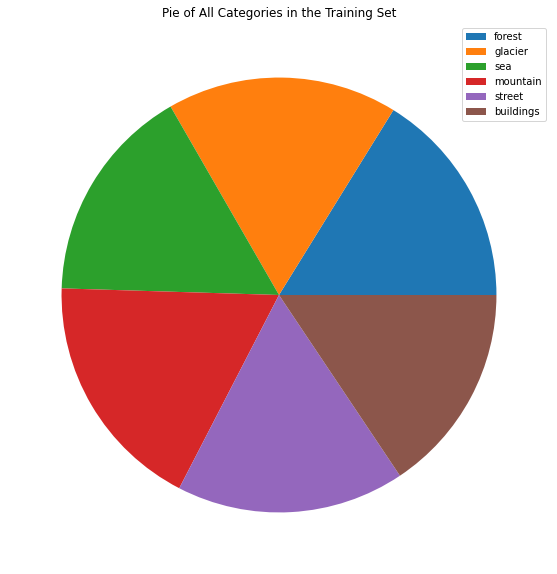

In [6]:
# Pie graph of the categories
plt.figure(figsize = (10,10))
plt.title("Pie of All Categories in the Training Set")
plt.pie(count)
plt.legend(classes)

There are ~ 14000 images in the training folder and, based on the pie graph, the six categories appear to be evenly split. 

In [7]:
# Check classes in test dataset
print(os.listdir(data_dir + '/seg_test/seg_test'))

# Check classes in prediction dataset
print(os.listdir(data_dir + '/seg_pred/seg_pred'))

['street', 'mountain', 'sea', 'glacier', 'forest', 'buildings']
['7028.jpg', '709.jpg', '7055.jpg', '7100.jpg', '7133.jpg', '7050.jpg', '7044.jpg', '7066.jpg', '7068.jpg', '7117.jpg', '7082.jpg', '7130.jpg', '7099.jpg', '7104.jpg', '7092.jpg', '7077.jpg', '7043.jpg', '7013.jpg', '7156.jpg', '7107.jpg', '7153.jpg', '7124.jpg', '705.jpg', '7075.jpg', '7137.jpg', '7147.jpg', '7160.jpg', '7109.jpg', '7115.jpg', '7190.jpg', '7219.jpg', '7242.jpg', '7186.jpg', '7162.jpg', '7249.jpg', '7208.jpg', '7211.jpg', '7243.jpg', '7177.jpg', '7194.jpg', '7230.jpg', '7213.jpg', '7210.jpg', '7224.jpg', '7257.jpg', '7217.jpg', '7244.jpg', '7183.jpg', '7218.jpg', '720.jpg', '718.jpg', '7187.jpg', '72.jpg', '7182.jpg', '7270.jpg', '7426.jpg', '7362.jpg', '7432.jpg', '7377.jpg', '7356.jpg', '7389.jpg', '7280.jpg', '7304.jpg', '7403.jpg', '7279.jpg', '7349.jpg', '7301.jpg', '7312.jpg', '7405.jpg', '7391.jpg', '7329.jpg', '7316.jpg', '734.jpg', '73.jpg', '7406.jpg', '7295.jpg', '7368.jpg', '7272.jpg', '7305.jp

The test dataset has classes while the prediction set does not, so we will use the test set as our validation set. Unfortunately, the prediction dataset cannot be used in its current state.

We will create a temporary training dataset using the `ImageFolder` class from `torchvision` using the `ToTensor` transform to take a peek into the characteristics of the pictures.

In [8]:
# Create temp training set
training_set = ImageFolder(data_dir + '/seg_train/seg_train', transform = tt.ToTensor())

In [9]:
# Check out the size of each picture
count = 0
for image,label in training_set:
    count += 1
    print(image.shape)
    print(training_set.classes[label])
    if count == 5:
        break

torch.Size([3, 150, 150])
buildings
torch.Size([3, 150, 150])
buildings
torch.Size([3, 150, 150])
buildings
torch.Size([3, 150, 150])
buildings
torch.Size([3, 150, 150])
buildings


It seems that the shape/size of each picture is `150 x 150`.

In [10]:
# Function to show an example of a picture with its label
def show_ex(img, label):
    print('Label: ' + training_set.classes[label] + ' (' + str(label) + ')')
    plt.imshow(img.permute(1, 2, 0))

Label: buildings (0)


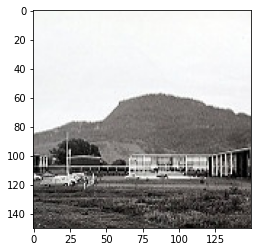

In [11]:
show_ex(*training_set[0])

Label: street (5)


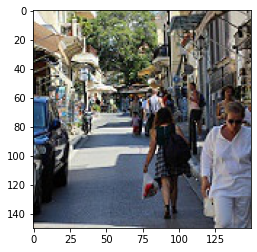

In [12]:
show_ex(*training_set[12000])

Label: forest (1)


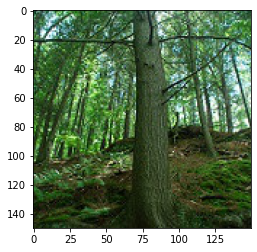

In [13]:
show_ex(*training_set[3000])

Label: sea (4)


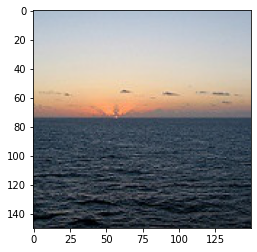

In [14]:
show_ex(*training_set[11000])

Label: glacier (2)


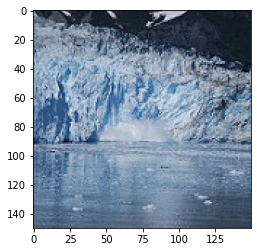

In [15]:
show_ex(*training_set[5000])

Label: mountain (3)


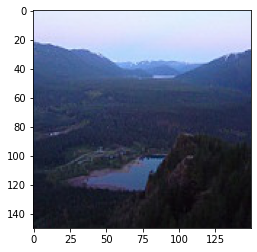

In [16]:
show_ex(*training_set[7000])

Above are examples of each of the six types of images we will be trying to classify. As we identified earlier, each picture size should be `150 x 150`, but we want to make sure that there are no discrepancies within the training set. To do so, we will go through each picture in the set to make sure that there are no issues.

In [17]:
# Loop through every picture in the set to check if they are standard size
count = 0
iteration = 0
id = []
low = 150
for image,_ in training_set:
    if image.shape != torch.Size([3, 150, 150]):
        count += 1
        low = min(low, image.shape[1], image.shape[2])
        print(image.shape)
        id.append(iteration)
    iteration += 1
print("Number of non-standard images: " + str(count))
print("Lowest image dimension: " + str(low))
print(id)

torch.Size([3, 124, 150])
torch.Size([3, 113, 150])
torch.Size([3, 108, 150])
torch.Size([3, 133, 150])
torch.Size([3, 115, 150])
torch.Size([3, 135, 150])
torch.Size([3, 136, 150])
torch.Size([3, 108, 150])
torch.Size([3, 113, 150])
torch.Size([3, 110, 150])
torch.Size([3, 105, 150])
torch.Size([3, 111, 150])
torch.Size([3, 120, 150])
torch.Size([3, 149, 150])
torch.Size([3, 143, 150])
torch.Size([3, 146, 150])
torch.Size([3, 134, 150])
torch.Size([3, 142, 150])
torch.Size([3, 123, 150])
torch.Size([3, 119, 150])
torch.Size([3, 102, 150])
torch.Size([3, 76, 150])
torch.Size([3, 97, 150])
torch.Size([3, 111, 150])
torch.Size([3, 111, 150])
torch.Size([3, 135, 150])
torch.Size([3, 134, 150])
torch.Size([3, 135, 150])
torch.Size([3, 123, 150])
torch.Size([3, 113, 150])
torch.Size([3, 142, 150])
torch.Size([3, 144, 150])
torch.Size([3, 103, 150])
torch.Size([3, 136, 150])
torch.Size([3, 144, 150])
torch.Size([3, 100, 150])
torch.Size([3, 143, 150])
torch.Size([3, 141, 150])
torch.Size([3,

Surprisingly, we find that there are 48 non-standard pictures within the training set with the lowest image dimension being 76. Let's see an example of a non-standard picture. 

Label: mountain (3)


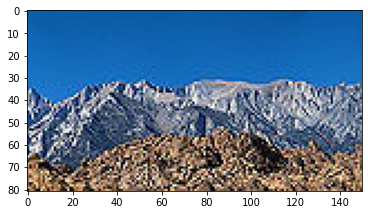

In [20]:
# Show an example of a non-standard picture 
show_ex(*training_set[9023])

## Preparing the Data
Now, we will prepare the data for input into the model. We want to make sure that the data, or pictures in this case, are all standardized. Next, we will also augment and normalize the data.

### Data Augmentation and Normalization Functions
1. Using the `Resize` function from `torchvision.transforms`, we are able to standardize all images to size `150 x 150`. 
2. The `RandomHorizontalFlip` function will randomly flip the images horizontally, so that the model will learn to expect multiple orientations. 
3. `ToTensor` will convert the image to a tensor. 
4. `Normalize` prevents pixel values from any one channel (RBG) from disproportionally affecting the losses and gradients.

In [21]:
# Transform the data (augmentation and normalization)
stats = ((0.4300, 0.4571, 0.4533), (0.2581, 0.2563, 0.2886))
train_tt = tt.Compose([tt.Resize((150, 150)), 
                       # tt.RandomCrop(size = 130, padding = 4, padding_mode = "reflect"),
                       # tt.RandomRotation(10),
                       tt.RandomHorizontalFlip(),
                       # tt.RandomVerticalFlip(), 
                       # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       tt.ToTensor(),
                       tt.Normalize(*stats, inplace = True)
])

valid_tt = tt.Compose([tt.Resize((150, 150)), tt.ToTensor(), tt.Normalize(*stats)])

In [22]:
# Create an ImageFolder with the new transformations for each dataset
train_ds = ImageFolder(data_dir + '/seg_train/seg_train', transform = train_tt)
valid_ds = ImageFolder(data_dir + '/seg_test/seg_test', transform = valid_tt)

Label: mountain (3)


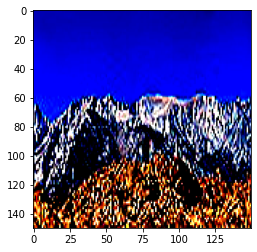

In [23]:
# A look at the new resized and normalized picture
show_ex(*train_ds[9023])

Label: forest (1)


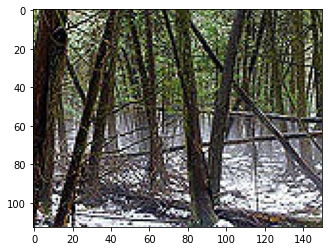

In [24]:
# Before resizing and normalization 
show_ex(*training_set[2196])

Label: forest (1)


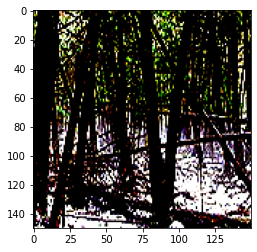

In [25]:
# After resizing and normalization 
show_ex(*train_ds[2196])

In [26]:
# Number of images per batch inputt
batch_size = 100

In [27]:
# Move datasets to the DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(valid_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Note that the training `DataLoader` is set to have `shuffle = True` so that the batch will have random images every time it is called, while `batch_size` determines the number of images in each `DataLoader`.

Let's take a look at the images in `train_dl`. To do so, we will create a `denormalize` function to revert the RGB values to normal. Then, we will code `show_batch` to display an `8 x 8` grid of 64 images from the dataset.

In [28]:
# Removes the color normalization by reversing tt.Normalize
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

# Function to show a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt. subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_imgs = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_imgs[:64], nrow = 8).permute(1, 2, 0).clamp(0, 1))
        break

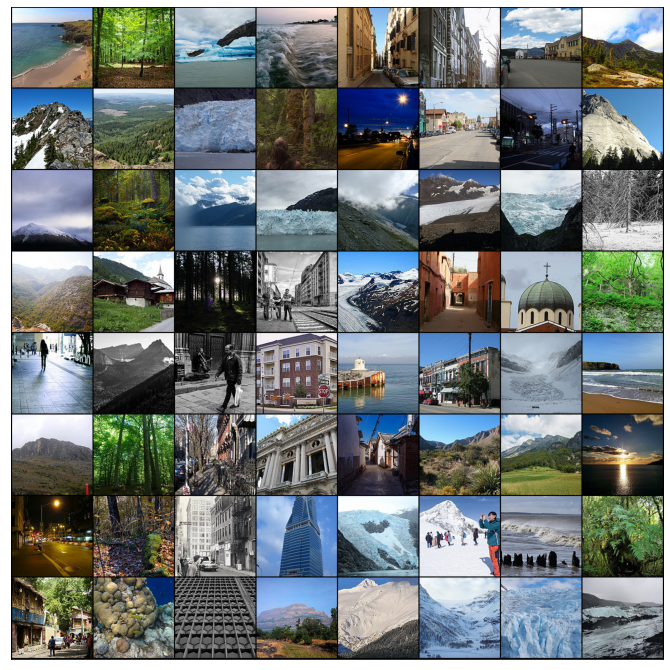

In [29]:
# A batch of images in grid format
show_batch(train_dl)

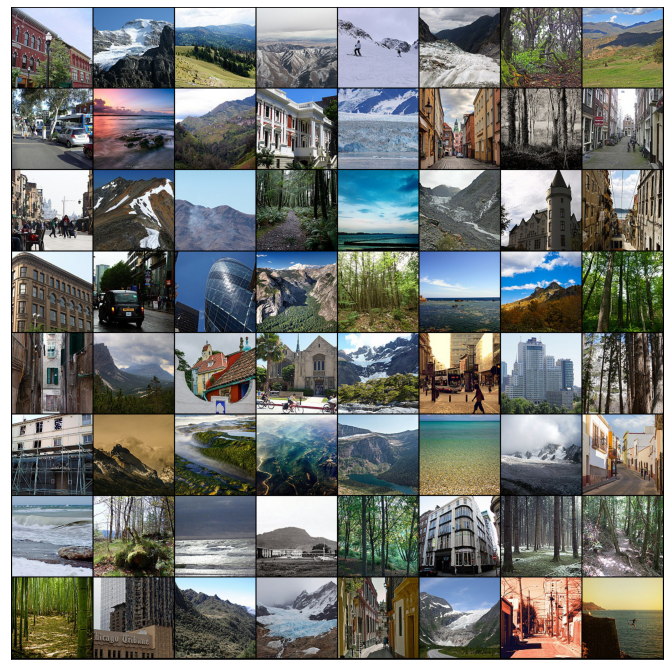

In [30]:
# Another batch but notice how its a different set
show_batch(train_dl)

In [31]:
# Same as show_batch but without the denormalization
def show_tt_batch(dl):
    for images, labels in dl:
        fig, ax = plt. subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow = 8).permute(1, 2, 0).clamp(0, 1))
        break

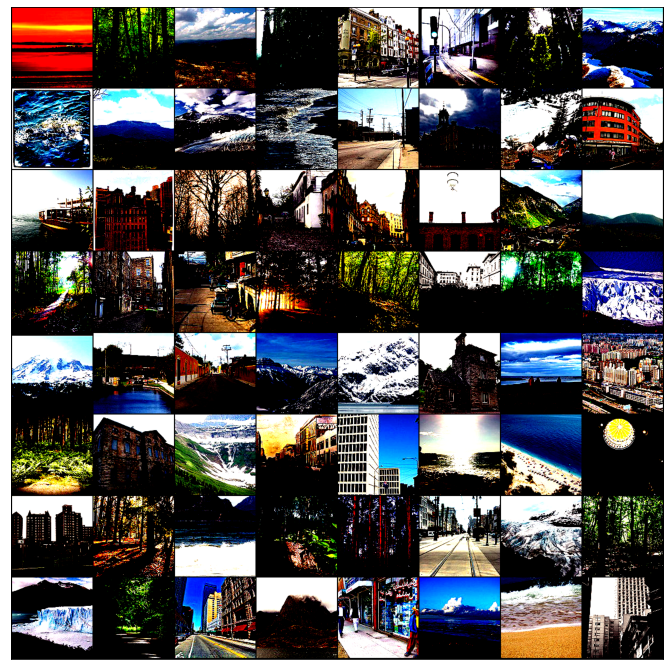

In [32]:
# Note how normalize affects the colors of the images
show_tt_batch(train_dl)

## Utilizing a GPU
Using a GPU will allow the model to do its computations much quicker as opposed to the weaker CPU. If this notebook is being run on Google Colab, make sure that you change the runtime type to GPU. To move the model and data to the GPU, we will define the `get_default_device` and `to_device` functions as well as the `DeviceDataLoader` class. 

In [33]:
# Gets the device (CPU or GPU) currently in use
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Moves data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

# Class utilized as a wrapper, data yielder, and length argument
class DeviceDataLoader():
    def __init__ (self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [34]:
# Return the device currently in use (CPU or GPU)
device = get_default_device()
device

device(type='cuda')

Move the datasets to the identified `device` (hopefully the GPU (`cuda`) for faster computation). 

In [35]:
# Wrap the data loaders in DeviceDataLoaders
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Creating the Model
From here on, we will be creating all the necessary parts for a working deep learning model. Our model is going to be a convolutional neural network (CNN) with a residual neural network (ResNet) architecture. 

### Model Basics
Write some basic reusable machine learning functions for training,  validation, and finding loss. These will be essential for running the model later.
1. The `accuracy` function will return the percent of correct values.
2. `training_step` will generate predictions based on the model and then find the real loss based on the `cross_entropy` loss function
3. `validation_step` does the same thing as `training_step` but also calculates the accuracy of predictions
4. `validation_epoch_end` combines the losses and accuracies and returns them
5. `epoch_end` prints the current state of the model and its most important parameters

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Neural Network Architecture
We will now write what will be the fundamental structure of our neural network. To make the code easier to read, we will write a `conv_block` to consisting of four `torch.nn` functions:
1. `Conv2d` is out convolutional layer
2. `BatchNorm2d` will normalize the ouputs from the `Conv2d` layer to make sure gradients and losses are not affected disproportionally
3. `ReLU`, or the rectified linear unit, will be our activation function that will add non-linearity
4. `MaxPool2d` will shrink the size of the image.

The defined `classifier` function will utilize `MaxPool2d` to form a size `1 x 1` image, while `Flatten` will flatten the tensor. `Dropout`, in this case, will drop 20% of the values to 0. A final `Linear` layer is used to match the many channels to the 6 image classes in the set.

In [37]:
# Basic convolutional layer block 
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace = True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 20) # 20 x 150 x 150
        self.conv2 = conv_block(20, 40, pool = True) # 40 x 75 x 75
        self.res1 = nn.Sequential(conv_block(40, 40), conv_block(40, 40)) # 40 x 75 x 75

        self.conv3 = conv_block(40, 80, pool = True) # 80 x 37 x 37
        self.conv4 = conv_block(80, 160, pool = True) # 160 x 18 x 18
        self.res2 = nn.Sequential(conv_block(160, 160), conv_block(160, 160)) # 160 x 18 x 18

        self.conv5 = conv_block(160, 320, pool = True) # 320 x 9 x 9
        self.conv6 = conv_block(320, 640, pool = True) # 640 x 4 x 4
        self.res3 = nn.Sequential(conv_block(640, 640), conv_block(640, 640)) # 640 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 640 x 1 x 1
                                        nn.Flatten(),    # 640
                                        nn.Dropout(0.2), 
                                        nn.Linear(640, num_classes)) # 640 -> 10
    # 13 layers 
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # Residual part
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out #
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out #
        out = self.classifier(out)
        return out

In [38]:
# Model is moved to the device 
model = to_device(ResNet(3, 6), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

## Training the Model
We will be improving our model with some small additions. 
1. **Learning rate scheduling**: Instead of a fixed learning rate, we will be using a learning rate scheduler which will change the learning rate after every batch of training. We will be using the "One Cycle Learning Rate Policy" which starts with a low learning rate and gradually increases to a high learning rate for ~ 30% of the epochs. It then gradually decreases to a very low value for the remaining epochs.
2. **Weight decay**: We will use weight decay, another regularization technique, to prevent weights from becoming too large by adding a multiplier to the loss function.
3. **Gradient clipping**: Gradient clipping limits the values of gradients (usually to small range) to prevent undesirable changes in parameters due to large gradient values. 

We will now define a `fit_one_cycle` that has learning rate scheduling in `torch.optim.lr_scheduler.OneCycleLR`, weight decay in `weight_decay`, and gradient clipping in `nn.utils.clip_grad_value_`. 

In [39]:
# Evaluates the current model on a dataset
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval() # Evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Gets learning rate from optimizer
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, modle, train_loader, val_loader, weight_decay = 0, 
                  grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

    # Set up a one cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, 
                                                steps_per_epoch = len(train_loader))

    for epoch in range(epochs):
        # Training phase
        model.train() # Training mode
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch) # Compute loss
            train_losses.append(loss)
            loss.backward()                   # Compute gradients

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()      # Update parameters based on gradients
            optimizer.zero_grad() # Zero out gradients

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader) # Compute accuracy & loss
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs 
        model.epoch_end(epoch, result)       # Print results
        history.append(result)
    return history 

In [40]:
# Evaluate the inital accuracy of the model
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.7922226190567017, 'val_acc': 0.16999998688697815}]

An initial accuracy around 0.166 (1/6) is to be expected since all weights and biases are randomly generated.

## Running the Model
We will now run the model. I will be using the `Adam` optimizer because it utilizes techniques like momentum and adaptive learning rates for faster training training compared to the `SGD` optimizer.

In [41]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [43]:
# Magic function
%%time 
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, grad_clip = grad_clip, 
                         weight_decay = weight_decay, opt_func = opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 0.7751, val_loss: 0.8997, val_acc: 0.6897
Epoch [1], last_lr: 0.00759, train_loss: 0.6653, val_loss: 0.8075, val_acc: 0.7027
Epoch [2], last_lr: 0.01000, train_loss: 0.6293, val_loss: 0.5687, val_acc: 0.7987
Epoch [3], last_lr: 0.00950, train_loss: 0.4955, val_loss: 0.7889, val_acc: 0.7260
Epoch [4], last_lr: 0.00812, train_loss: 0.4615, val_loss: 0.4898, val_acc: 0.8180
Epoch [5], last_lr: 0.00611, train_loss: 0.3764, val_loss: 0.6592, val_acc: 0.7543
Epoch [6], last_lr: 0.00389, train_loss: 0.3374, val_loss: 0.3680, val_acc: 0.8657
Epoch [7], last_lr: 0.00188, train_loss: 0.2718, val_loss: 0.3187, val_acc: 0.8857
Epoch [8], last_lr: 0.00050, train_loss: 0.2186, val_loss: 0.2769, val_acc: 0.8997
Epoch [9], last_lr: 0.00000, train_loss: 0.1846, val_loss: 0.2755, val_acc: 0.9000
CPU times: user 4min 6s, sys: 3min 55s, total: 8min 2s
Wall time: 9min 28s


Wow! We managed to achieve ~ 90% accuracy on the validation dataset within ~ 9 minutes and 28 seconds. In some cases, the time it takes may be longer. Unfortunately, I was not able to get the accuracy above 90% with the current model any way I tried.

In [45]:
# Time it took to train
train_time = '9:28'

Let's plot some graphs to see some of the trends that could be found within the model. We will start by seeing how the accuracy improved over the epochs. 

In [46]:
# Line plot of accuracies over epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

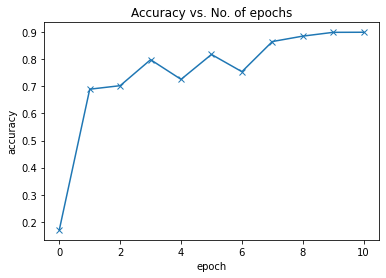

In [47]:
plot_accuracies(history)

The graph climbs steeply and gradually flattens around `0.90` accuracy. This seems to be limit of the model and will not improve much with more epochs.

We will also see how the loss for the training and validation sets decreased over time. We will want them to hand in hand in the end.

In [48]:
# Double line graph of training and validation loss over epochs
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

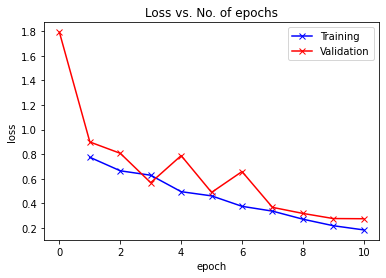

In [49]:
plot_losses(history)

From the graph, we can see how the training and validation losses are about the same, and there is little overfitting.

Below, we can see the `OneCycleLR` in action.

In [50]:
# Line graph of learning rate over batches
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

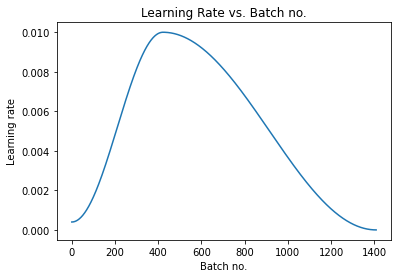

In [51]:
plot_lrs(history)

Notice how the learning rate starts very low and then sharply climbs to the `max_lr` to fall back down gradually to a lower learning rate. 

## Predicting Images
Let's predict some images from the validation dataset, as we do not have a working test dataset.

In [52]:
# Returns the model's prediction
def predict_img(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return valid_ds.classes[preds[0].item()]

# Denormalizes the image 
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return images * stds + means

In [53]:
# Returns the prediction and actual label along with the image
def img_predictions(num):
    img, label = valid_ds[num]
    plt.imshow(denormalize(img, *stats).permute(1, 2, 0).clamp(0, 1))
    print('Label:', valid_ds.classes[label], ', Predicted:', predict_img(img, model))

Label: glacier , Predicted: glacier


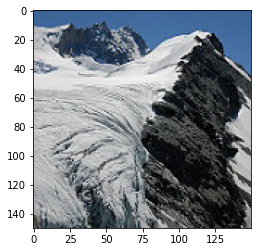

In [54]:
img_predictions(1340)

Label: buildings , Predicted: buildings


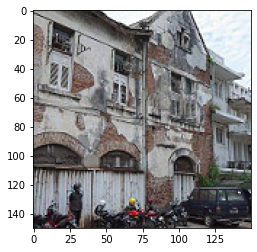

In [55]:
img_predictions(134)

Label: forest , Predicted: forest


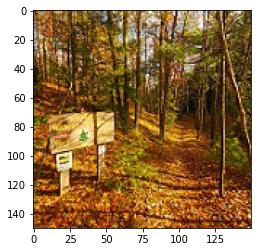

In [56]:
img_predictions(560)

Label: street , Predicted: street


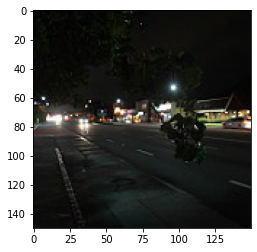

In [57]:
img_predictions(2680)

Label: mountain , Predicted: mountain


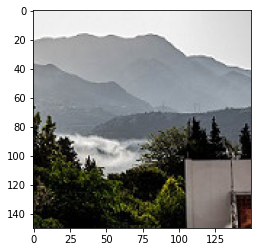

In [58]:
img_predictions(1800)

Label: buildings , Predicted: buildings


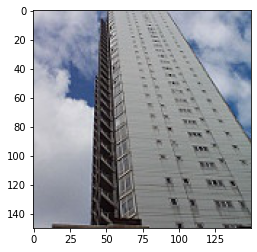

In [59]:
img_predictions(425)

Label: buildings , Predicted: street


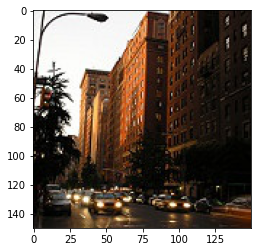

In [60]:
img_predictions(254)

Well...it is only 90% correct.

## Save
Now, let's save the weights of our model.

In [61]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Image Classification/intel-image-classification-cp.pth')